In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
torch.set_num_threads(4)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


### Create signal

In [2]:
DEVICE = 'cuda:0'

FREERUN = 1000
Ns = 20000+FREERUN
signal = signalz.mackey_glass(Ns, a=0.2, b=0.8, c=0.9, d=23, e=10, initial=0.1)
signal = signal - np.mean(signal)
print(f'\nsignal mean={np.mean(signal)}')
M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 300
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST

SIGNUM = 2      
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
STD = np.std(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal Length M = {M}')
print(f'minmax = {MINMAX}')
print(f'std = {STD}')


signal mean=-6.580979147873308e-17
Signal Length M = 20000
minmax = 1.611402028919085
std = 0.3429382374043401


In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### Loading and saving dicts

In [4]:
#with open('Dicts/diagMG.json', 'w') as fp:
#    json.dump(dict_diag, fp, cls=NumpyArrayEncoder)
#with open('Dicts/modelsMG.json', 'w') as fp:
#    json.dump(dict_models, fp, cls=NumpyArrayEncoder)
    
fpath = 'Dicts/diagMG.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts/modelsMG.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

### Plot low-error model counts by size

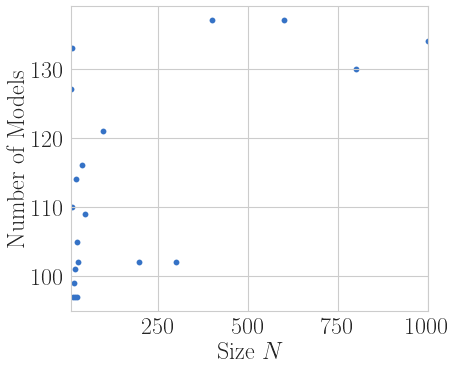

In [5]:
size = [1000, 800, 600, 400, 300, 200, 100, 50, 40,
        30, 28, 26, 24, 22, 20, 18, 16, 14, 12,10]

mean_errors = []
num_models = []

for i in size:
    try:
        err = np.max(dict_diag[str(i)]['meanError'])
    except:
        err = 0
    if(np.isnan(err)):
        err=0
    mean_errors.append(err)
    
    try:
        num = dict_diag[str(i)]['numModels']
    except:
        num = 0
    if(np.isnan(err)):
        num = 0
    num_models.append(num)
np.save('num_modelsMG',num_models)

plt.scatter(size[::-1],num_models[::-1])
plt.xlabel('Size $N$')
plt.ylabel('Number of Models')
plt.show()

In [8]:
#np.save('mean_errorMG_2',mean_errors)

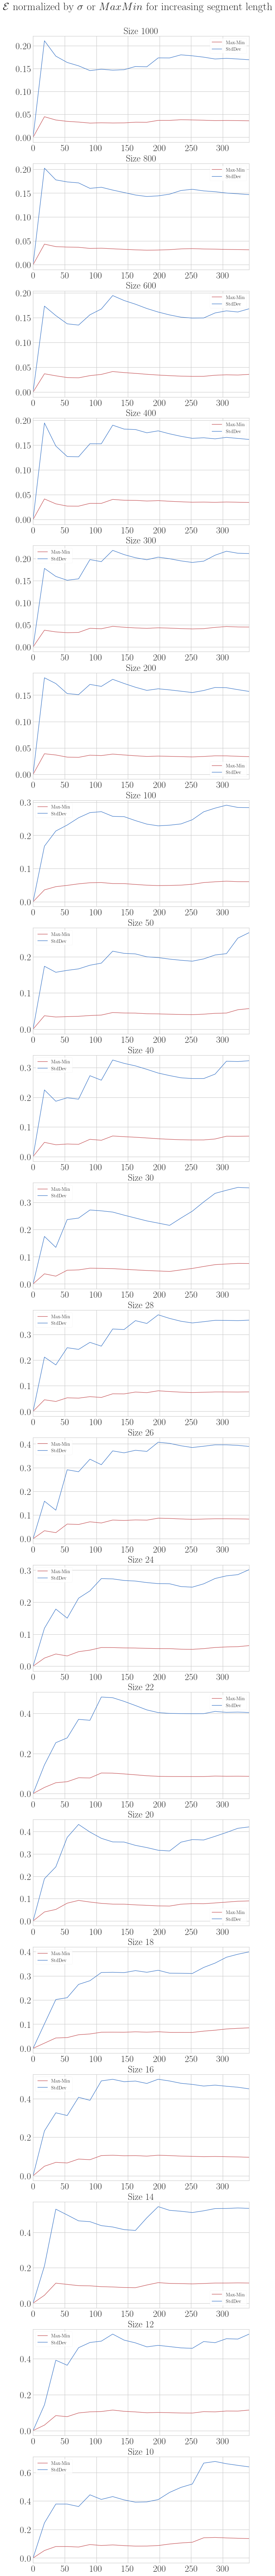

In [9]:
import pdb
def debug():
    #pdb.set_trace()
    Nplots= len(size)
    Nsegs = 20
    stpsz = 15
    segment_errMM = np.zeros((Nplots,Nsegs))
    segment_errSTD = np.zeros((Nplots,Nsegs))
    seglengths = np.zeros((1,Nsegs))
    for n in range(Nplots):
        try:
            preds = np.squeeze(np.array(dict_models[str(size[n])]['Preds']))
        except:
            print(f'Skipped {n}')
            continue
        for i in range(1,Nsegs):
            #print(f'{n}   {i}')
            sigchk = signal[TRAINLENGTH:TRAINLENGTH+i*stpsz]
            predschk = preds[TRAINLENGTH:TRAINLENGTH+i*stpsz]
            predschk = np.nan_to_num(predschk, nan=5)
            errMM = rca.NRMSE(sigchk,
                              predschk,
                              MINMAX)
            errSTD = rca.NRMSE(sigchk,
                               predschk,
                               STD)
            segment_errMM[n,i] = errMM
            segment_errSTD[n,i] = errSTD
            seglengths[0,i] = i*18

    fig, axs = plt.subplots(Nplots, figsize=(10,6*Nplots)) 
    fig.suptitle('$\mathcal{E}$ normalized by $\sigma$ or $MaxMin$ for increasing segment length'
                 , y=.89, fontsize=28)
    for n in range(Nplots):
        axs[n].set_title(f'Size {size[n]}')
        axs[n].plot(seglengths[0,:], segment_errMM[n,:],
                 color='r', label=f'Max-Min')
        axs[n].plot(seglengths[0,:], segment_errSTD[n,:],
                 color='b', label=f'StdDev')
        axs[n].legend()
    #fig.tight_layout()
    plt.show()
    
debug()

### 2D plots of target with prediction

In [ ]:
Nplots= len(size)
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
axs[0].set_title('Signal $MG$ predictions $t=0,\dots,T^{\rm test}-1$')
for n in range(Nplots):
    if(dict_diag[str(size[n])]['numModels']==0):
        continue
    axs[n].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='k', label='target')
    preds = dict_models[str(size[n])]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    
    Ekl = error_testset*kl
    print(f'N={size[n]}   Error = {np.round(error_testset,2)} KL-div = {np.round(kl,2)} E*kl={Ekl:.3f}')
    axs[n].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             color='b', label=f'preds{size[n]}')
    axs[n].legend()
plt.show()

### Calculate Rank Method-1 for all sizes

In [ ]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)
all_ranks = []
measured = []
K = 1
L = 1
tols = [1/10**x for x in range(5,20)]
plt.figure()
for i in range(Nplots):
    n = size[i]
    if(dict_diag[str(n)]['numModels']==0):
        all_ranks.append(0)
        continue
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    sr = p[1]
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    grads = np.gradient(rkc)
    v = np.argmax(grads)
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    if((v+1) == len(tols)):
        ave_rank = (rkc[v]+rkc[v-1])//2
    else:
        ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(2)}')
    print(f'Alpha {np.round(a,2)} --- Rho {np.round(sr,2)}\n')
    all_ranks.append(ave_rank)
    measured.append(n)
plt.title('Rank vs Tolerance for various size $N$')
plt.xlabel('Tolerance $\epsilon > 10^{-x}$')
plt.ylabel('$\mathrm{rank(C_{N};\epsilon)}$')
plt.ylim(0,50)
plt.show()

### Log-Log Plot Rank Method-1 vs Size

In [ ]:
plt.loglog(size[::-1],all_ranks[::-1], label='indicated')
plt.loglog(size[::-1],size[::-1], label='N')
plt.xlabel('Size $N$')
plt.ylabel('$\mathrm{rank}(C_N)$')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

In [ ]:
#np.save('ranksMG_2',all_ranks)

### Get time-step of divergence as measured by $R_{\mathbf{xy}}[k]$ correlation at each $t$

### Get time-step of divergence

In [ ]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))
FREE =1000
T = M + FREE
Nsizes = len(size)
correlations = np.zeros((Nsizes,T))
thresholds = np.zeros(Nsizes)
threshold_location = np.zeros(Nsizes, dtype=int)
for i in range(4,Nsizes):
    if(dict_diag[str(size[i])]['numModels']==0):
        continue
    k = size[i]
    corr_length = T-k # calculate for j= 0,..., M-k
    pred = np.array(dict_models[str(k)]['Preds']) # Get size N predictions
    
    for j in range(corr_length):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        correlations[i,j] = Rxy(tar,prd)

    minVal = correlations[i,TRAINLENGTH-1000:TRAINLENGTH].min()
    thresholds[i] = minVal*.95
    threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
    print(f'k-size={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
          f' Location={threshold_location[i]}')


### Plot divergence

In [ ]:
LEAD = 100
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
for n in range(Nsizes):
    if(dict_diag[str(size[n])]['numModels']==0):
        continue
    pred = dict_models[str(size[n])]['Preds']
    axs[n].plot(signal[TRAINLENGTH-LEAD:TRAINLENGTH+TEST], color='k', label='target')
    axs[n].plot(pred[TRAINLENGTH-LEAD:TRAINLENGTH+TEST],color='b', label='pred')
    axs[n].plot(correlations[n,TRAINLENGTH-LEAD:TRAINLENGTH+TEST], color='r', label=f'k={size[n]}')
    axs[n].axvline(LEAD+threshold_location[n],color='r', linestyle='dashed', label=f't={threshold_location[n]}')
    axs[n].axvline(LEAD,color='k')
    axs[n].axhline(thresholds[n],color='r', linestyle='dashed')
    axs[n].set_ylabel('$\mathbf{R}_{xy}[k]\enspace ,\enspace MG$')
    axs[n].set_xlabel('Time-steps $t$')
    axs[n].legend(fontsize=24,loc='lower right')
axs[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
plt.show()

### Chaos plot

In [ ]:
import seaborn as sns
import pandas as pd
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance, delX):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    conds = np.zeros(T)
    radii = np.zeros(T)
    uncertainty = np.zeros((n,T))
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        conds[i] = rca.condition_number(A)[0]
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        uncertainty[:,i] = np.squeeze(np.dot(A,delX))
        Cplus = rca.controllability_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
        print(f'Time-step: {i} Rank: {ranks[i]} Uncertainty: {np.linalg.norm(uncertainty):.2f}  CondNum: {conds[i]:.2f}')
    return ranks, uncertainty, conds, radii




n=28
pred = np.array(dict_models[str(n)]['Preds'])
data_dict = {'y': signal[14000:],
             'yh': np.squeeze(pred[14000:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)
fig= plt.figure(figsize=(10,14))
ax1 = plt.subplot(211)
sns.distplot(df['y'],
             label='$MG$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha))
sns.distplot(df['yh'],
             label='$\widehat{\mathbf{y}},\,N=28$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha))
plt.legend(loc='upper left', fontsize=fontsize)
plt.ylabel(r'${P}(u_t)$', fontsize=26,  color='black', weight='heavy')
plt.xlabel(r'Range of $u_t$', fontsize=26,  color='black', weight='heavy')
plt.xticks(c='black', fontsize=fontsize)
plt.yticks(c='black', fontsize=fontsize)
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')

ax2 = plt.subplot(212)
plt.rcParams['xtick.major.pad']='8'
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.plot(signal[TRAINLENGTH-100:TRAINLENGTH+TEST],'k', label=r'$MG$')
ax2.plot(pred[TRAINLENGTH-100:TRAINLENGTH+TEST],'b-', label='$\widehat{\mathbf{y}},\,N=28$')
ax2.axvline(100, c='k',ls='dashed' )
ax2.axvline(100+12, c='r',ls='dashed' )

ax2.legend(loc='lower right',fontsize=20)
ax2.set_xticks([0,100,200,300,400])
ax2.set_xticklabels([-100,0,100,200,300])
ax2.set_xlabel('Test Data Time-steps '+'($t$)', fontsize=26, color='black', weight='heavy')
ax2.set_ylabel(r'${u_{t+1} - \mu}$', fontsize=26, color='black', weight='heavy')
plt.show()
fig.savefig("Fig7.pdf", format='pdf',dpi=300, bbox_inches='tight', pad_inches=.01)
fig.savefig("Fig7.png", format='png',dpi=300, bbox_inches='tight', pad_inches=.01)